In [1]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
#import weatherbench2 as wb
#import metpy
import copy
import wrf
import time
#from metpy.units import units
import cartopy.crs as ccrs
print('modules loaded')
import datetime
import glob
import datetime as dt
import seaborn as sns
import netCDF4 as nc
import metpy
from metpy.units import units
from glob import glob

modules loaded


In [2]:
figpath='/users/mfeldman/figs/case_24/'
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/'
models=['aifs','pangu','graphcast','tigge']

In [3]:
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([2020]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([4]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([2,3]),latitude=slice(20,50),longitude=slice(250,300))
zsurf_c=xr_era5['geopotential_at_surface']

year=2024; month=4; day=np.arange(2,4,1); days=day[0]-np.arange(1,10)
print(days)
latslice2=slice(20,50)
for model in models[2:-1]:
    files_pl=sorted(glob(datapath+model+'/pl*.nc'))
    files_sfc=sorted(glob(datapath+model+'/sfc*.nc'))
    for nn in range(len(files_pl))[:]:
        st=datetime.datetime(2024,4,2,0)
        et=datetime.datetime(2024,4,3,23)


        print(files_pl[nn])
        xr_pl=xr.open_dataset(files_pl[nn]).sortby('latitude')
        init=np.datetime_as_string(xr_pl.time[0].values,'h')
        
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.year.isin([year]))
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.month.isin([month]))
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.day.isin([day]))
        
        xr_sfc=xr.open_dataset(files_sfc[nn]).sortby('latitude')
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.year.isin([year]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.month.isin([month]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.day.isin([day]))


        xr_pl = xr_pl.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_pl.level.values)
        
        tlevel=xr_pl.t
        qlevel=xr_pl.q
        plevel_dim=np.ones([1,len(plevel),1,1])
        if model=='tigge': zlevel=xr_pl.gh * 9.81
        else: zlevel=xr_pl.z
        ulevel=xr_pl.u
        vlevel=xr_pl.v
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        psurf=xr_sfc.msl
        tsurf=xr_sfc.t2m
        zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        # zsurf = zsurf.expand_dims(dim={"time": psurf.time}, axis=1)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
        mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
        mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
        mod_inst=mod_inst.assign_coords(time=psurf.time.values)

        du_01=ulevel.sel(level=850)-xr_sfc.u10; dv_01=vlevel.sel(level=850)-xr_sfc.v10
        du_03=ulevel.sel(level=700)-xr_sfc.u10; dv_03=vlevel.sel(level=700)-xr_sfc.v10
        du_06=ulevel.sel(level=500)-xr_sfc.u10; dv_06=vlevel.sel(level=500)-xr_sfc.v10
        
        bs_01=( du_01**2 + dv_01**2 )**0.5
        bs_03=( du_03**2 + dv_03**2 )**0.5
        bs_06=( du_06**2 + dv_06**2 )**0.5
        
        du_01=du_01.to_dataset(name='du_01')
        dv_01=dv_01.to_dataset(name='dv_01')
        bs_01=bs_01.to_dataset(name='bs_01')
        du_03=du_03.to_dataset(name='du_03')
        dv_03=dv_03.to_dataset(name='dv_03')
        bs_03=bs_03.to_dataset(name='bs_03')
        du_06=du_06.to_dataset(name='du_06')
        dv_06=dv_06.to_dataset(name='dv_06')
        bs_06=bs_06.to_dataset(name='bs_06')
        
        mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
        #mod_params=mod_params.squeeze(dim='level')
        
        if model=='tigge': mod_params['cape']=xr_sfc.cape
        else: mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
        mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
        mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
        mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
        mod_params['q500']=qlevel.sel(level=500).squeeze()
        mod_params['t500']=tlevel.sel(level=500).squeeze()
        mod_params['q925']=qlevel.sel(level=925).squeeze()
        mod_params['t925']=tlevel.sel(level=925).squeeze()
        print(model,init)
        mod_params.to_netcdf(datapath+'postproc/'+model+'_'+init+'.nc')

        # cm=plt.cm.Reds
        # cm.set_under(color="grey")
        # cm.set_bad(color="grey")
        # p = mod_params.cape.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
        #                 ,cmap=cm,vmin=200,vmax=1500,levels=np.arange(200,1500,100),extend='both')# col_wrap=4)
        # for ax in p.axs.flat:
        #                 ax.coastlines()
        # f=p.fig
        # f.savefig(figpath+model+'_'+init+'_cape.png',  dpi=300, bbox_inches='tight')
        # plt.close()
        
        # cm=plt.cm.Reds
        # cm.set_under(color="grey")
        # cm.set_bad(color="grey")
        # p = mod_params.bs_06.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
        #                 ,cmap=cm,vmin=5,vmax=30,levels=np.arange(5,32,2),extend='both')# col_wrap=4)
        # for ax in p.axs.flat:
        #                 ax.coastlines()
        # f=p.fig
        # f.savefig(figpath+model+'_'+init+'_bs_06.png',  dpi=300, bbox_inches='tight')
        # plt.close()


[ 1  0 -1 -2 -3 -4 -5 -6 -7]
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-23_00:00:00.nc
graphcast 2024-03-23T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-23_12:00:00.nc
graphcast 2024-03-23T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-24_00:00:00.nc
graphcast 2024-03-24T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-24_12:00:00.nc
graphcast 2024-03-24T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-25_00:00:00.nc
graphcast 2024-03-25T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-25_12:00:00.nc
graphcast 2024-03-25T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-26_00:00:00.nc
graphcast 2024-03-26T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/graphcast/pl_2024-03-26_12:00:00.nc
graphcast 2024-03-26T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_d

In [75]:
for model in models[-1:]:
    files_pl=sorted(glob(datapath+model+'/pl*.nc'))
    files_sfc=sorted(glob(datapath+model+'/sfc*.nc'))
    for nn in range(len(files_pl))[:]:
        st=datetime.datetime(2024,4,2,0)
        et=datetime.datetime(2024,4,3,23)


        print(files_pl[nn])
        xr_pl=xr.open_dataset(files_pl[nn]).sortby('latitude')
        init=np.datetime_as_string(xr_pl.time[0].values,'h')
        
        xr_sfc=xr.open_dataset(files_sfc[nn]).sortby('latitude')
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.year.isin([year]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.month.isin([month]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.day.isin([day]))

        cm=plt.cm.Reds
        cm.set_under(color="grey")
        cm.set_bad(color="grey")
        p = xr_sfc.cape.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                        ,cmap=cm,vmin=200,vmax=1500,levels=np.arange(200,1500,100),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+'_'+init+'_cape_mod.png',  dpi=300, bbox_inches='tight')
        plt.close()

/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-23_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-23_12:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-24_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-24_12:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-25_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-25_12:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-26_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-26_12:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-27_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-27_12:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/tigge/pl_2024-03-28_00:00:00.nc
/work/FAC/FGSE/IDYST/tbeucler/de

In [7]:
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([2020]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([4]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([2,3]),latitude=slice(20,50),longitude=slice(250,300))
zsurf_c=xr_era5['geopotential_at_surface']

models2=['sfno','fuxi']
year=2024; month=4; day=np.arange(2,4,1); days=day[0]-np.arange(1,10)
print(days)
latslice2=slice(20,50)
for model in models2[:]:
    files_pl=sorted(glob(datapath+model+'/pl*.nc'))
    files_sfc=sorted(glob(datapath+model+'/sfc*.nc'))
    for nn in range(len(files_pl))[:]:
        st=datetime.datetime(2024,4,2,0)
        et=datetime.datetime(2024,4,3,23)


        print(files_pl[nn])
        xr_pl=xr.open_dataset(files_pl[nn]).sortby('latitude')
        init=np.datetime_as_string(xr_pl.time[0].values,'h')
        
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.year.isin([year]))
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.month.isin([month]))
        xr_pl=xr_pl.sel(time=xr_pl.time.dt.day.isin([day]))
        
        xr_sfc=xr.open_dataset(files_sfc[nn]).sortby('latitude')
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.year.isin([year]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.month.isin([month]))
        xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.day.isin([day]))


        xr_pl = xr_pl.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_pl.level.values)
        
        tlevel=xr_pl.t
        rlevel=xr_pl.r
        plevel_dim=np.ones([1,len(plevel),1,1])
        zlevel=xr_pl.z
        ulevel=xr_pl.u
        vlevel=xr_pl.v
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim

        dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
        qlevel=metpy.calc.specific_humidity_from_dewpoint(plevel_exp.values* units('hPa'), dplevel).to('kg/kg').magnitude
        
        psurf=xr_sfc.msl
        tsurf=xr_sfc.t2m
        zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        # zsurf = zsurf.expand_dims(dim={"time": psurf.time}, axis=1)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        q1level=copy.deepcopy(tlevel)
        q1level.data=qlevel
        
        mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=q1level, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
        mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
        mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
        mod_inst=mod_inst.assign_coords(time=psurf.time.values)

        du_01=ulevel.sel(level=850)-xr_sfc.u10; dv_01=vlevel.sel(level=850)-xr_sfc.v10
        du_03=ulevel.sel(level=700)-xr_sfc.u10; dv_03=vlevel.sel(level=700)-xr_sfc.v10
        du_06=ulevel.sel(level=500)-xr_sfc.u10; dv_06=vlevel.sel(level=500)-xr_sfc.v10
        
        bs_01=( du_01**2 + dv_01**2 )**0.5
        bs_03=( du_03**2 + dv_03**2 )**0.5
        bs_06=( du_06**2 + dv_06**2 )**0.5
        
        du_01=du_01.to_dataset(name='du_01')
        dv_01=dv_01.to_dataset(name='dv_01')
        bs_01=bs_01.to_dataset(name='bs_01')
        du_03=du_03.to_dataset(name='du_03')
        dv_03=dv_03.to_dataset(name='dv_03')
        bs_03=bs_03.to_dataset(name='bs_03')
        du_06=du_06.to_dataset(name='du_06')
        dv_06=dv_06.to_dataset(name='dv_06')
        bs_06=bs_06.to_dataset(name='bs_06')
        
        mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
        #mod_params=mod_params.squeeze(dim='level')
        mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
        mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
        mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
        mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
        mod_params['q500']=q1level.sel(level=500).squeeze()*100
        mod_params['r500']=rlevel.sel(level=500).squeeze()*100
        mod_params['t500']=tlevel.sel(level=500).squeeze()
        mod_params['q925']=q1level.sel(level=925).squeeze()*100
        mod_params['r925']=rlevel.sel(level=925).squeeze()*100
        mod_params['t925']=tlevel.sel(level=925).squeeze()
        print(model,init)
        # p=plt.imshow(q1level.sel(level=925)[-1,:,:])
        # plt.colorbar(p)
        # plt.show()
        mod_params.to_netcdf(datapath+'postproc/'+model+'_'+init+'.nc')

        # cm=plt.cm.Reds
        # cm.set_under(color="grey")
        # cm.set_bad(color="grey")
        # p = mod_params.cape.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
        #                 ,cmap=cm,vmin=200,vmax=1500,levels=np.arange(200,1500,100),extend='both')# col_wrap=4)
        # for ax in p.axs.flat:
        #                 ax.coastlines()
        # f=p.fig
        # f.savefig(figpath+model+'_'+init+'_cape.png',  dpi=300, bbox_inches='tight')
        # plt.close()
        
        # cm=plt.cm.Reds
        # cm.set_under(color="grey")
        # cm.set_bad(color="grey")
        # p = mod_params.bs_06.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
        #                 ,cmap=cm,vmin=5,vmax=30,levels=np.arange(5,32,2),extend='both')# col_wrap=4)
        # for ax in p.axs.flat:
        #                 ax.coastlines()
        # f=p.fig
        # f.savefig(figpath+model+'_'+init+'_bs_06.png',  dpi=300, bbox_inches='tight')
        # plt.close()
        



[ 1  0 -1 -2 -3 -4 -5 -6 -7]
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-23_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-23T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-23_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-23T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-24_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-24T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-24_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-24T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-25_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-25T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-25_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-25T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-26_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-26T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-26_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-26T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-27_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-27T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-27_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-27T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-28_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-28T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-28_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-28T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-29_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-29T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-29_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-29T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-30_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-30T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-30_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-30T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-31_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-31T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-03-31_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-03-31T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-01_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-01T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-01_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-01T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-02_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-02T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-02_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-02T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-03_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-03T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/sfno/pl_2024-04-03_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


sfno 2024-04-03T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-23_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-23T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-23_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-23T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-24_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-24T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-24_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-24T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-25_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-25T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-25_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-25T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-26_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-26T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-26_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-26T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-27_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-27T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-27_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-27T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-28_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-28T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-28_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-28T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-29_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-29T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-29_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-29T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-30_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-30T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-30_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-30T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-31_00:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-31T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-03-31_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-03-31T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-01_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-01T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-01_12:00:00.nc


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-01T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-02_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-02T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-02_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-02T12
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-03_00:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-03T00
/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/fuxi/pl_2024-04-03_12:00:00.nc


/tmp/ipykernel_3689385/3985743562.py:48: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_relative_humidity(tlevel.values* units('K'), rlevel.values* units.percent)
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


fuxi 2024-04-03T12


In [14]:
mod_params.drop(['level','mcape_mcin_lcl_lfc'])

/tmp/ipykernel_3689385/3299110031.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mod_params.drop(['level','mcape_mcin_lcl_lfc'])


<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, time: 2)
Coordinates:
  * longitude  (longitude) float32 250.0 250.2 250.5 250.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * time       (time) datetime64[ns] 2024-04-03T12:00:00 2024-04-03T18:00:00
Data variables: (12/19)
    du_01      (time, latitude, longitude) float32 -2.493 -2.597 ... -4.826
    dv_01      (time, latitude, longitude) float32 4.112 3.687 ... -4.504 -3.77
    bs_01      (time, latitude, longitude) float32 4.809 4.51 ... 6.066 6.124
    du_03      (time, latitude, longitude) float32 7.561 7.633 ... -4.667 -4.486
    dv_03      (time, latitude, longitude) float32 8.106 7.692 ... 1.143 2.325
    bs_03      (time, latitude, longitude) float32 11.08 10.84 ... 4.805 5.053
    ...         ...
    q500       (time, latitude, longitude) float64 0.06094 0.06826 ... 0.02128
    r500       (time, latitude, longitude) float32 1.285e+03 ... 5.039e+03
    t500       (time, latitude, longitude) float32 266.8 266.9 ... 239.1 238.9
    q925       (time, latitude, longitude) float64 0.7545 0.8189 ... 0.1854
    r925       (time, latitude, longitude) float32 7.209e+03 ... 6.088e+03
    t925       (time, latitude, longitude) float32 286.7 286.5 ... 269.2 269.1

(array([16696.,  9730.,  7442.,  4379.,  4137.,  3050.,  1365.,  1027.,
          685.,    24.]),
 array([3.68133717e-07, 4.67697145e-04, 9.35026156e-04, 1.40235517e-03,
        1.86968418e-03, 2.33701319e-03, 2.80434220e-03, 3.27167121e-03,
        3.73900022e-03, 4.20632923e-03, 4.67365824e-03]),
 <BarContainer object of 10 artists>)

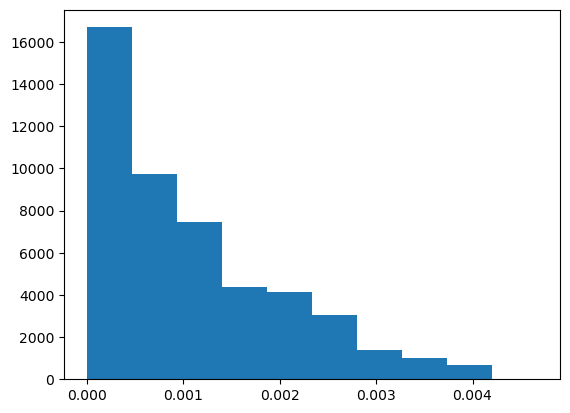

In [14]:
plt.hist(q1level.sel(level=500).values.flatten())

In [6]:
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([2020]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([4]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([2,3]),latitude=slice(20,50),longitude=slice(250,300))
zsurf_c=xr_era5['geopotential_at_surface']

year=2024; month=4; day=np.arange(2,4,1); days=day[0]-np.arange(1,10)
print(days)
latslice2=slice(20,50)
model='era5'
file_pl=sorted(glob(datapath+model+'/*pl*.nc'))[0]
file_rh=sorted(glob(datapath+model+'/*rh*.nc'))[0]
file_sfc=sorted(glob(datapath+model+'/*sfc*.nc'))[0]

st=datetime.datetime(2024,4,2,0)
et=datetime.datetime(2024,4,3,23)


#print(files_pl[nn])
xr_pl=xr.open_dataset(file_pl).sortby('latitude')
init=np.datetime_as_string(xr_pl.time[0].values,'h')

xr_pl=xr_pl.sel(time=xr_pl.time.dt.year.isin([year]))
xr_pl=xr_pl.sel(time=xr_pl.time.dt.month.isin([month]))
xr_pl=xr_pl.sel(time=xr_pl.time.dt.day.isin([day]))

xr_sfc=xr.open_dataset(file_sfc).sortby('latitude')
xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.year.isin([year]))
xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.month.isin([month]))
xr_sfc=xr_sfc.sel(time=xr_sfc.time.dt.day.isin([day]))

xr_rh=xr.open_dataset(file_rh).sortby('latitude')
xr_rh=xr_rh.sel(time=xr_rh.time.dt.year.isin([year]))
xr_rh=xr_rh.sel(time=xr_rh.time.dt.month.isin([month]))
xr_rh=xr_rh.sel(time=xr_rh.time.dt.day.isin([day]))


xr_pl = xr_pl.sortby('level', ascending=False)

plevel=copy.deepcopy(xr_pl.level.values)

tlevel=xr_pl.t
qlevel=xr_pl.q
rlevel=xr_rh.r
plevel_dim=np.ones([1,len(plevel),1,1])
if model=='tigge': zlevel=xr_pl.gh
else: zlevel=xr_pl.z
ulevel=xr_pl.u
vlevel=xr_pl.v
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim

psurf=xr_sfc.msl
tsurf=xr_sfc.t2m
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
# zsurf = zsurf.expand_dims(dim={"time": psurf.time}, axis=1)

ps=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

mod_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=psurf, ter_follow=False)
mod_inst=mod_inst.assign_coords(longitude=psurf.longitude.values);
mod_inst=mod_inst.assign_coords(latitude=psurf.latitude.values);
mod_inst=mod_inst.assign_coords(time=psurf.time.values)

du_01=ulevel.sel(level=850)-xr_sfc.u10n; dv_01=vlevel.sel(level=850)-xr_sfc.v10n
du_03=ulevel.sel(level=700)-xr_sfc.u10n; dv_03=vlevel.sel(level=700)-xr_sfc.v10n
du_06=ulevel.sel(level=500)-xr_sfc.u10n; dv_06=vlevel.sel(level=500)-xr_sfc.v10n

bs_01=( du_01**2 + dv_01**2 )**0.5
bs_03=( du_03**2 + dv_03**2 )**0.5
bs_06=( du_06**2 + dv_06**2 )**0.5

du_01=du_01.to_dataset(name='du_01')
dv_01=dv_01.to_dataset(name='dv_01')
bs_01=bs_01.to_dataset(name='bs_01')
du_03=du_03.to_dataset(name='du_03')
dv_03=dv_03.to_dataset(name='dv_03')
bs_03=bs_03.to_dataset(name='bs_03')
du_06=du_06.to_dataset(name='du_06')
dv_06=dv_06.to_dataset(name='dv_06')
bs_06=bs_06.to_dataset(name='bs_06')

mod_params=xr.merge([du_01,dv_01,bs_01,du_03,dv_03,bs_03,du_06,dv_06,bs_06],compat='override')
#mod_params=mod_params.squeeze(dim='level')
mod_params['cape']=mod_inst.sel(mcape_mcin_lcl_lfc='mcape')
mod_params['cin']=mod_inst.sel(mcape_mcin_lcl_lfc='mcin')
mod_params['lcl']=mod_inst.sel(mcape_mcin_lcl_lfc='lcl')
mod_params['lfc']=mod_inst.sel(mcape_mcin_lcl_lfc='lfc')#.squeeze(dim='mcape_mcin_lcl_lfc')
mod_params['q500']=qlevel.sel(level=500).squeeze()
mod_params['r500']=rlevel.sel(level=500).squeeze()
mod_params['t500']=tlevel.sel(level=500).squeeze()
mod_params['q925']=qlevel.sel(level=925).squeeze()
mod_params['r925']=rlevel.sel(level=925).squeeze()
mod_params['t925']=tlevel.sel(level=925).squeeze()
#print(model,init)
mod_params.to_netcdf(datapath+'postproc/'+model+'.nc')


cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
p = mod_params.cape.sel(latitude=slice(20,40),longitude=slice(-100,-70)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=1500,levels=np.arange(200,1500,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+model+'_cape.png',  dpi=300, bbox_inches='tight')
plt.close()

cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
p = mod_params.bs_06.sel(latitude=slice(20,40),longitude=slice(-100,-70)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=5,vmax=30,levels=np.arange(5,32,2),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+model+'_bs_06.png',  dpi=300, bbox_inches='tight')
plt.close()


[ 1  0 -1 -2 -3 -4 -5 -6 -7]


In [5]:
file_pl

['/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/era5/case_24_era_pl.nc']

(array([7.2376e+04, 4.4658e+04, 2.2891e+04, 2.0443e+04, 2.0254e+04,
        9.1000e+03, 3.3170e+03, 1.1760e+03, 3.1800e+02, 3.5000e+01]),
 array([6.51925802e-09, 4.77505557e-04, 9.55004594e-04, 1.43250369e-03,
        1.91000267e-03, 2.38750177e-03, 2.86500086e-03, 3.34249996e-03,
        3.81999882e-03, 4.29749815e-03, 4.77499701e-03]),
 <BarContainer object of 10 artists>)

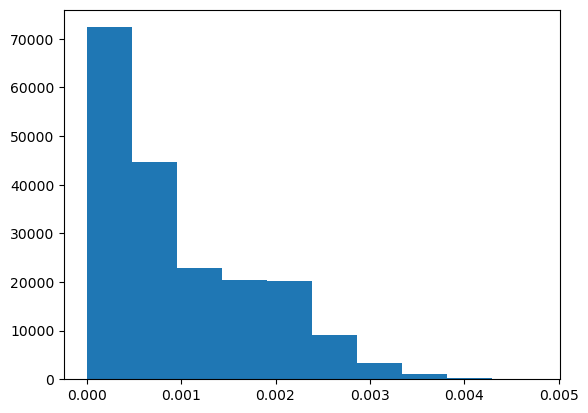

In [15]:
plt.hist(qlevel.sel(level=500).values.flatten())

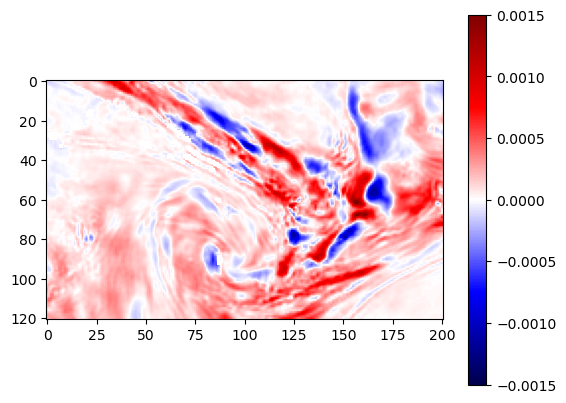

In [44]:
p=plt.imshow(q1level.sel(level=500)[1,:,:].values-qlevel.sel(level=500)[7,:,:].values,cmap='seismic',vmin=-0.0015,vmax=0.0015)
plt.colorbar(p)

In [48]:
q1level.values[1,:,3,3]
#plevel

array([8.77411138e-03, 5.46625684e-03, 5.88469179e-04, 2.91803391e-04,
                  nan, 2.38610271e-05, 9.25232525e-05, 6.13869087e-05,
       1.58240316e-04, 1.14631211e-04, 2.26130395e-05, 5.48979125e-06,
       5.17938240e-06])

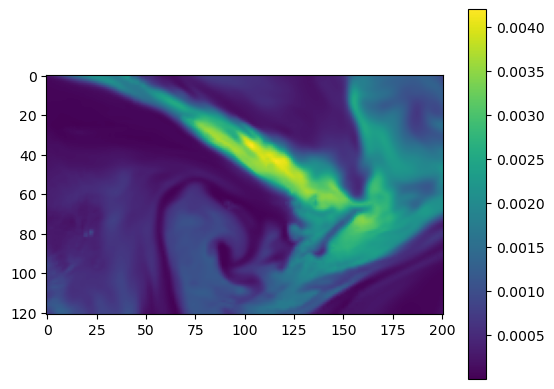

In [41]:
p=plt.imshow(qlevel.sel(level=500)[7,:,:])
plt.colorbar(p)

In [9]:
xr_sfc.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, time: 8)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.8 -109.5 ... -60.5 -60.25 -60.0
  * latitude   (latitude) float32 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * time       (time) datetime64[ns] 2024-04-02 ... 2024-04-03T18:00:00
Data variables:
    u10n       (time, latitude, longitude) float32 ...
    v10n       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 1.015e+05 ... 1.023e+05
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-09 13:30:58 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>